In [1]:
%matplotlib inline
import pymc3 as pm
import theano.tensor as T
import theano
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale


import warnings
from scipy import VisibleDeprecationWarning
warnings.filterwarnings("ignore", category=VisibleDeprecationWarning) 

sns.set_context('notebook')


In [2]:
X, Y = sklearn.datasets.make_blobs(n_samples=1000, centers=2, random_state=1)
X = scale(X)
colors = Y.astype(str)
colors[Y == 0] = 'r'
colors[Y == 1] = 'b'

interval = 20
subsample = X.shape[0] // interval
chunk = np.arange(0, X.shape[0]+1, subsample)
degs = np.linspace(0, 360, len(chunk))

sep_lines = []

for ii, (i, j, deg) in enumerate(list(zip(np.roll(chunk, 1), chunk, degs))[1:]):
    theta = np.radians(deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix([[c, -s], [s, c]])

    X[i:j, :] = X[i:j, :].dot(R)

In [3]:
import base64
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""


def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        anim.save("test.mp4", fps=20, extra_args=['-vcodec', 'libx264'])

        video = open("test.mp4","rb").read()

    anim._encoded_video = base64.b64encode(video).decode('utf-8')
    return VIDEO_TAG.format(anim._encoded_video)

from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))
from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
ims = [] #l, = plt.plot([], [], 'r-')
for i in np.arange(0, len(X), 10):
    ims.append([(ax.scatter(X[:i, 0], X[:i, 1], color=colors[:i]))])

ax.set(xlabel='X1', ylabel='X2')
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.ArtistAnimation(fig, ims,
                                 interval=500, 
                                 blit=True);

display_animation(anim)

In [4]:
from pymc3 import HalfNormal, GaussianRandomWalk, Bernoulli
from pymc3.math import sigmoid
import theano.tensor as tt


X_shared = theano.shared(X)
Y_shared = theano.shared(Y)

n_dim = X.shape[1] # 2

with pm.Model() as random_walk_perceptron:
    step_size = pm.HalfNormal('step_size', sd=np.ones(n_dim), 
                              shape=n_dim)
    
    # This is the central trick, PyMC3 already comes with this distribution
    w = pm.GaussianRandomWalk('w', sd=step_size, 
                              shape=(interval, 2))
    
    weights = tt.repeat(w, X_shared.shape[0] // interval, axis=0)
    
    class_prob = sigmoid(tt.batched_dot(X_shared, weights))
    
    # Binary classification -> Bernoulli likelihood
    pm.Bernoulli('out', class_prob, observed=Y_shared)

In [5]:
with random_walk_perceptron:
    trace_perceptron = pm.sample(2000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [00:44<00:00, 56.33it/s]


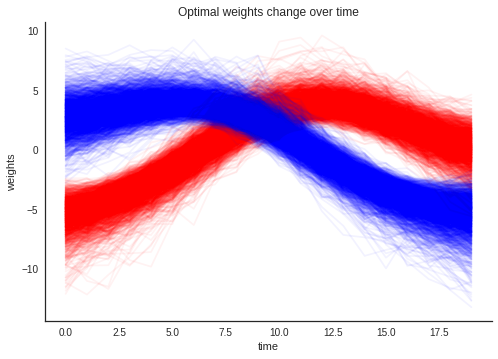

In [6]:
plt.plot(trace_perceptron['w'][:, :, 0].T, alpha=.05, color='r');
plt.plot(trace_perceptron['w'][:, :, 1].T, alpha=.05, color='b');
plt.xlabel('time'); plt.ylabel('weights'); plt.title('Optimal weights change over time'); sns.despine();

In [7]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = grid.reshape(2, -1).T
grid_2d = np.tile(grid_2d, (interval, 1))
dummy_out = np.ones(grid_2d.shape[0], dtype=np.int8)

X_shared.set_value(grid_2d)
Y_shared.set_value(dummy_out)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace_perceptron, model=random_walk_perceptron, samples=500)

def create_surface(X, Y, grid, ppc, fig=None, ax=None):
    artists = []
    cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
    contour = ax.contourf(*grid, ppc, cmap=cmap)
    artists.extend(contour.collections)
    artists.append(ax.scatter(X[Y==0, 0], X[Y==0, 1], color='b'))
    artists.append(ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r'))
    _ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X1', ylabel='X2');
    return artists

fig, ax = plt.subplots()
chunk = np.arange(0, X.shape[0]+1, subsample)
chunk_grid = np.arange(0, grid_2d.shape[0]+1, 10000)
axs = []
for (i, j), (i_grid, j_grid) in zip((list(zip(np.roll(chunk, 1), chunk))[1:]), (list(zip(np.roll(chunk_grid, 1), chunk_grid))[1:])):
    a = create_surface(X[i:j], Y[i:j], grid, ppc['out'][:, i_grid:j_grid].mean(axis=0).reshape(100, 100), fig=fig, ax=ax)
    axs.append(a)
    
anim2 = animation.ArtistAnimation(fig, axs,
                                 interval=1000);
display_animation(anim2)

100%|██████████| 500/500 [00:26<00:00, 18.64it/s]


In [8]:
from sklearn.datasets import make_moons
X, Y = make_moons(noise=0.2, random_state=0, n_samples=5000)
X = scale(X)

colors = Y.astype(str)
colors[Y == 0] = 'r'
colors[Y == 1] = 'b'

interval = 20
subsample = X.shape[0] // interval
chunk = np.arange(0, X.shape[0]+1, subsample)
degs = np.linspace(0, 360, len(chunk))

sep_lines = []

for ii, (i, j, deg) in enumerate(list(zip(np.roll(chunk, 1), chunk, degs))[1:]):
    theta = np.radians(deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix([[c, -s], [s, c]])

    X[i:j, :] = X[i:j, :].dot(R)

In [9]:
fig, ax = plt.subplots()
ims = []
for i in np.arange(0, len(X), 10):
    ims.append((ax.scatter(X[:i, 0], X[:i, 1], color=colors[:i]),))

ax.set(xlabel='X1', ylabel='X2')
anim = animation.ArtistAnimation(fig, ims,
                                 interval=500, 
                                 blit=True);

display_animation(anim)

In [10]:
np.random.seed(123)

ann_input = theano.shared(X)
ann_output = theano.shared(Y)

n_hidden = [2, 5]

# Initialize random weights between each layer
init_1 = np.random.randn(X.shape[1], n_hidden[0]).astype(theano.config.floatX)
init_2 = np.random.randn(n_hidden[0], n_hidden[1]).astype(theano.config.floatX)
init_out = np.random.randn(n_hidden[1]).astype(theano.config.floatX)
    
with pm.Model() as neural_network:
    # Weights from input to hidden layer
    step_size = pm.HalfNormal('step_size', sd=np.ones(n_hidden[0]), 
                              shape=n_hidden[0])
    
    weights_in_1 = pm.GaussianRandomWalk('w1', sd=step_size, 
                                         shape=(interval, X.shape[1], n_hidden[0]),
                                         testval=np.tile(init_1, (interval, 1, 1))
                                        )
    
    weights_in_1_rep = tt.repeat(weights_in_1, 
                                 ann_input.shape[0] // interval, axis=0)
    
    weights_1_2 = pm.Normal('w2', mu=0, sd=1., 
                            shape=(1, n_hidden[0], n_hidden[1]),
                            testval=init_2)
    
    weights_1_2_rep = tt.repeat(weights_1_2, 
                                ann_input.shape[0], axis=0)
    
    weights_2_out = pm.Normal('w3', mu=0, sd=1.,
                              shape=(1, n_hidden[1]),
                              testval=init_out)
    
    weights_2_out_rep = tt.repeat(weights_2_out, 
                                  ann_input.shape[0], axis=0)
      

    # Build neural-network using tanh activation function
    act_1 = tt.tanh(tt.batched_dot(ann_input, 
                         weights_in_1_rep))
    act_2 = tt.tanh(tt.batched_dot(act_1, 
                         weights_1_2_rep))
    act_out = tt.nnet.sigmoid(tt.batched_dot(act_2, 
                                             weights_2_out_rep))
        
    # Binary classification -> Bernoulli likelihood
    out = pm.Bernoulli('out', 
                       act_out,
                       observed=ann_output)

In [11]:
import scipy.optimize
with neural_network:
    map_est = pm.find_MAP(fmin=scipy.optimize.fmin_l_bfgs_b)

/opt/conda/lib/python3.6/site-packages/pymc3/tuning/starting.py:91: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = -14.171: : 5001it [00:41, 120.95it/s]


StopIteration: 

In [ ]:
plt.plot(map_est['w1'].reshape(20, 4));

In [ ]:
ppc = pm.sample_ppc([map_est], model=neural_network, samples=1)
print('Accuracy on train data = {:.2f}%'.format((ppc['out'] == Y).mean() * 100))

In [ ]:
with neural_network:
    trace = pm.sample(1000, tune=200)

In [ ]:
plt.plot(trace['w1'][200:, :, 0, 0].T, alpha=.05, color='r');
plt.plot(trace['w1'][200:, :, 0, 1].T, alpha=.05, color='b');
plt.plot(trace['w1'][200:, :, 1, 0].T, alpha=.05, color='g');
plt.plot(trace['w1'][200:, :, 1, 1].T, alpha=.05, color='c');

plt.xlabel('time'); plt.ylabel('weights'); plt.title('Optimal weights change over time'); sns.despine();

In [ ]:
ppc = pm.sample_ppc(trace, model=neural_network, samples=100)
print('Accuracy on train data = {:.2f}%'.format(((ppc['out'].mean(axis=0) > .5) == Y).mean() * 100))

In [ ]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = grid.reshape(2, -1).T
grid_2d = np.tile(grid_2d, (interval, 1))
dummy_out = np.ones(grid_2d.shape[0], dtype=np.int8)

ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)

fig, ax = plt.subplots()
chunk = np.arange(0, X.shape[0]+1, subsample)
chunk_grid = np.arange(0, grid_2d.shape[0]+1, 10000)
axs = []
for (i, j), (i_grid, j_grid) in zip((list(zip(np.roll(chunk, 1), chunk))[1:]), (list(zip(np.roll(chunk_grid, 1), chunk_grid))[1:])):
    a = create_surface(X[i:j], Y[i:j], grid, ppc['out'][:, i_grid:j_grid].mean(axis=0).reshape(100, 100), fig=fig, ax=ax)
    axs.append(a)
    
anim2 = animation.ArtistAnimation(fig, axs,
                                  interval=1000);
display_animation(anim2)

In [ ]:
fig, ax = plt.subplots()
chunk = np.arange(0, X.shape[0]+1, subsample)
chunk_grid = np.arange(0, grid_2d.shape[0]+1, 10000)
axs = []
for (i, j), (i_grid, j_grid) in zip((list(zip(np.roll(chunk, 1), chunk))[1:]), (list(zip(np.roll(chunk_grid, 1), chunk_grid))[1:])):
    a = create_surface(X[i:j], Y[i:j], grid, ppc['out'][:, i_grid:j_grid].std(axis=0).reshape(100, 100), 
                       fig=fig, ax=ax)
    axs.append(a)

anim2 = animation.ArtistAnimation(fig, axs,
                                  interval=1000);
display_animation(anim2)